# Q-Learning Example Mountain - Car v0

## Libraries - Setup

In [ ]:
import gym
try :
  # In Google Colab
  %tensorflow_version 2.x
except :
    pass

# Import Tensorflow
import tensorflow as tf

# Assure TensorFlow version >= 2 is installed. Otherwise install TensorFlow 2.0 version.
try :
    assert tf.__version__ >= "2.0"
    print ("TensorFlow version found:", tf.__version__)
except :
    !pip install tensorflow==2.4

# Import NumPy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version found: 2.12.0


In [ ]:
# #remove " > /dev/null 2>&1" to see what is going on under the hood
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1
# !apt-get install x11-utils > /dev/null 2>&1

In [ ]:
# import base64

# from IPython.display import HTML
# from IPython import display as ipythondisplay

# try:
#     from pyvirtualdisplay import Display
#     display = Display(visible=0, size=(1400, 900))
#     display.start()
# except ImportError:
#     pass

## Plots and Animations Functions

In [ ]:
# Creates an image for the environment
def plot_environment(env, figsize = (5,4)):
    plt.figure( figsize = figsize)
    img = env.render(mode = "rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [ ]:
#Stores all the images to create an animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

## Create Environment

In [ ]:
env = gym.make("MountainCar-v0") # three actions that you can take
# action 0 push the car left
# action 1 do nothing
# action 2 push the car right
env.reset()

array([-0.54450613,  0.        ], dtype=float32)

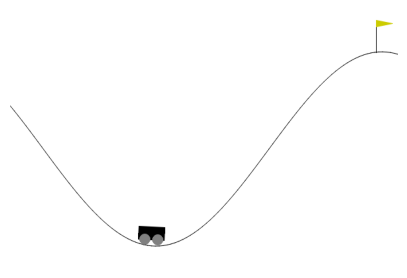

In [ ]:
plot_environment(env)
plt.show()

In [ ]:
type(env.observation_space.low)


numpy.ndarray

## Q-Table Initialization and Q-Learning

In [ ]:
env.seed(42)
frames=[]

LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 20000

SHOW_FRAME = 5000
SAVE_QTABLE = 100
SHOW_EVERY = 500

DISCRETE_OS_SIZE=[20]*len(env.observation_space.high)
discrete_os_win_size= (env.observation_space.high - env.observation_space.low)/ DISCRETE_OS_SIZE

epsilon = 0.5
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2


epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

q_table = np.random.uniform(low=2,high=0,size=(DISCRETE_OS_SIZE + [env.action_space.n]))

ep_rewards = [] # the rewards of all the episodes
aggr_ep_rewards = { 'ep': [], 'avg': [], 'min': [], 'max': []}

def get_discrete_state(state):

  discrete_state = (state - env.observation_space.low) / discrete_os_win_size
  return tuple(discrete_state.astype(np.int))


for episode in range(EPISODES):

  episode_reward = 0

  discrete_state = get_discrete_state(env.reset())

  done=False

  while not done:

    if np.random.random() > epsilon:
      action = np.argmax(q_table[discrete_state])
    else:
      action = np.random.randint(0, env.action_space.n)

    new_state, reward, done, info = env.step(action)
    episode_reward += reward
    new_discrete_state = get_discrete_state(new_state)

    #print(reward,new_state)

    if not done:
      max_future_q = np.max(q_table[new_discrete_state])
      current_q = q_table[discrete_state + (action, )]

      new_q = (1-LEARNING_RATE)*current_q+LEARNING_RATE*(reward + DISCOUNT*max_future_q)

      q_table[discrete_state+(action, )] = new_q
    elif new_state[0] >= env.goal_position:
      #print(f"We made it to the top at episode {episode}")
      q_table[discrete_state+ (action, )] = 0

    discrete_state = new_discrete_state

    if episode % SHOW_FRAME == 0:
      img = env.render(mode="rgb_array")
      frames.append(env.render(mode ="rgb_array"))

  if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
    epsilon -= epsilon_decay_value

  ep_rewards.append(episode_reward)

  if episode % SAVE_QTABLE:

    np.save(f"qtables/{episode}-qtable.npy", q_table)


  if episode % SHOW_EVERY == 0:
    average_reward = sum(ep_rewards[-SHOW_EVERY:])/len(ep_rewards[-SHOW_EVERY:])
    aggr_ep_rewards['ep'].append(episode)
    aggr_ep_rewards['avg'].append(average_reward)
    aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
    aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))

    print(f"Episode: {episode}, avg: {average_reward}, min: {min(ep_rewards[-SHOW_EVERY:])}, max: {max(ep_rewards[-SHOW_EVERY:])}")




<ipython-input-19-7a862f37b705>:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


Episode: 0, avg: -200.0, min: -200.0, max: -200.0
Episode: 500, avg: -200.0, min: -200.0, max: -200.0
Episode: 1000, avg: -199.958, min: -200.0, max: -181.0
Episode: 1500, avg: -199.866, min: -200.0, max: -155.0
Episode: 2000, avg: -199.218, min: -200.0, max: -159.0
Episode: 2500, avg: -199.19, min: -200.0, max: -159.0
Episode: 3000, avg: -198.226, min: -200.0, max: -154.0
Episode: 3500, avg: -197.644, min: -200.0, max: -151.0
Episode: 4000, avg: -192.054, min: -200.0, max: -149.0
Episode: 4500, avg: -192.482, min: -200.0, max: -146.0
Episode: 5000, avg: -194.778, min: -200.0, max: -146.0
Episode: 5500, avg: -182.2, min: -200.0, max: -115.0
Episode: 6000, avg: -180.078, min: -200.0, max: -125.0
Episode: 6500, avg: -184.864, min: -200.0, max: -145.0
Episode: 7000, avg: -182.16, min: -200.0, max: -136.0
Episode: 7500, avg: -177.086, min: -200.0, max: -118.0
Episode: 8000, avg: -170.688, min: -200.0, max: -114.0
Episode: 8500, avg: -182.552, min: -200.0, max: -117.0
Episode: 9000, avg: -1

In [ ]:
len(frames)

651

## Plots and Results

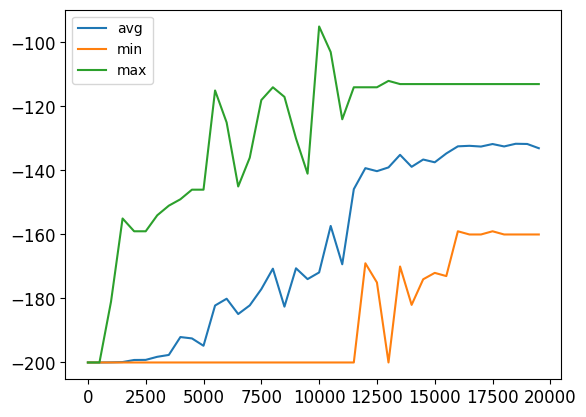

In [ ]:
#plt.figure(figsize=(10,7))
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="avg")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max")
plt.legend(loc=2 )
plt.show()

In [ ]:
import matplotlib
#matplotlib.rcParams['animation.embed_limit'] = 2**128
plot_animation(frames)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066


KeyboardInterrupt: ignored

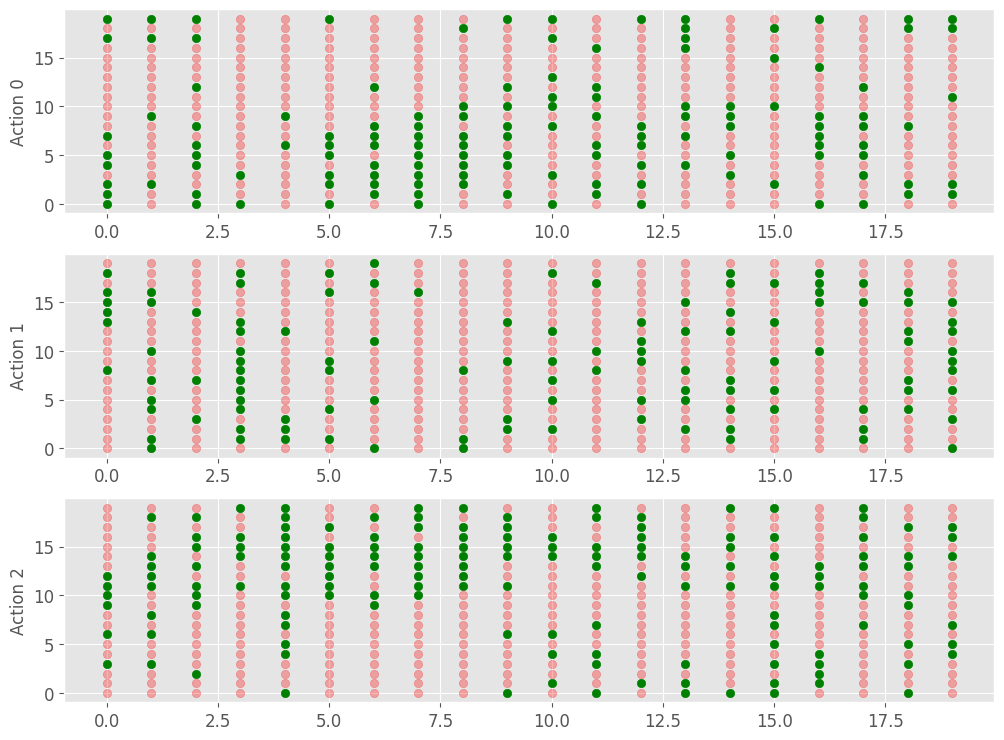

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')


def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    else:
        return "red", 0.3


fig = plt.figure(figsize=(12, 9))


for i in range(10001, 10900, 1):
    print(i)
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    q_table = np.load(f"qtables/{i}-qtable.npy")

    for x, x_vals in enumerate(q_table):
        for y, y_vals in enumerate(x_vals):
            ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
            ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
            ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

            ax1.set_ylabel("Action 0")
            ax2.set_ylabel("Action 1")
            ax3.set_ylabel("Action 2")

    #plt.show()
    plt.savefig(f"{i}.png")
    plt.clf()

In [ ]:
import cv2
import os


def make_video():
    # windows:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # Linux:
    #fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter('qlearn.avi', fourcc, 60.0, (1200, 900))

    for i in range(10001, 10034, 1):
        img_path = f"{i}.png"
        print(img_path)
        frame = cv2.imread(img_path)
        out.write(frame)

    out.release()


make_video()

10001.png
10002.png
10003.png
10004.png
10005.png
10006.png
10007.png
10008.png
10009.png
10010.png
10011.png
10012.png
10013.png
10014.png
10015.png
10016.png
10017.png
10018.png
10019.png
10020.png
10021.png
10022.png
10023.png
10024.png
10025.png
10026.png
10027.png
10028.png
10029.png
10030.png
10031.png
10032.png
10033.png


# Q-Learning Creating our own Enviroment Tutorial

## Libraries - Setup

In [ ]:
import gym
try :
  # In Google Colab
  %tensorflow_version 2.x
except :
  pass

# Import Tensorflow
import tensorflow as tf

# Assure TensorFlow version >= 2 is installed. Otherwise install TensorFlow 2.0 version.
try :
  assert tf.__version__ >= "2.0"
  print ("TensorFlow version found:", tf.__version__)
except :
  !pip install tensorflow==2.4

# Import NumPy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import pickle
from matplotlib import style
import time
from PIL import Image

style.use("ggplot")
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version found: 2.12.0


In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

try:
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()
except ImportError:
    pass

## Plots and Animations Functions

In [ ]:
# Creates an image for the environment
def plot_environment(env, figsize = (5,4)):
    plt.figure( figsize = figsize)
    img = env.render(mode = "rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Stores all the images to create an animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

## Create Environment

First we define our variables for our enviroment and for our Q-learning

In [ ]:
SIZE = 10
HM_EPISODES = 25000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25
episode_rewards = []
FRAMES = []
epsilon =0.9
EPS_DECAY = 0.9998

SHOW_EVERY = 5000
SHOW_FRAMES = 5000
SHOW_QTABLE = 200

start_q_table = None # or filename so we would take an already q table

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3

d = {1: (255,175,0), 2: (0,255,0),3: (0,0,255)}

Now we will create our blob class for the example

In [ ]:
class Blob:
  def __init__(self):
    self.x = np.random.randint(0,SIZE)
    self.y = np.random.randint(0,SIZE)

  def __str__(self):
    return f"{self.x}, {self.y}"

  def __sub__(self, other):
    return (self.x - other.x,self.y - other.y)

  def action(self, choice):
    if choice == 0:
      self.move(x = 1,y = 1)
    if choice == 1:
      self.move(x = -1,y = -1)
    if choice == 2:
      self.move(x = -1,y = 1)
    if choice == 3:
      self.move(x = 1,y = -1)

  def move(self,x=False,y=False):
    if not x:
      self.x += np.random.radnint(-1,2)
    else:
      self.x += x
    if not y:
      self.y += np.random.radnint(-1,2)
    else:
      self.y += y

    if self.x < 0:
      self.x = 0
    elif self.x > SIZE-1:
      self.x = SIZE-1

    if self.y < 0:
      self.y = 0
    elif self.y > SIZE-1:
      self.y = SIZE-1

if start_q_table is None:
  q_table = {}
  for x1 in range(-SIZE+1,SIZE):
      for y1 in range(-SIZE+1,SIZE):
          for x2 in range(-SIZE+1,SIZE):
              for y2 in range(-SIZE+1,SIZE):
                q_table[((x1,y1),(x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]
else:
  with open(start_qtable, "rb") as f:
    q_table = pickle.load(f)

## Q-Table Initialization and Q-Learning

In [ ]:
for episode in range(HM_EPISODES):
  player = Blob()
  food = Blob()
  enemy = Blob()

  if episode % SHOW_EVERY == 0:
    print(f"on # {episode}, epsilon:{epsilon}")
    print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
    show = True
  else:
    show = False

  episode_reward = 0
  for i in range(200):
    obs = (player-food, player-enemy)
    if np.random.random() > epsilon:
      action = np.argmax(q_table[obs])
    else:
      action = np.random.randint(0,4)
    player.action(action)

    ### maybe later
    #food.move()
    #enemy.move
    ###

    if player.x == enemy.x and player.y == enemy.y:
      reward = -ENEMY_PENALTY

    elif player.x == food.x and player.y == food.y:
      reward = FOOD_REWARD
    else:
      reward = -MOVE_PENALTY

    new_obs = (player - food, player - enemy)
    max_future_q = np.max(q_table[new_obs])
    current_q = q_table[obs][action]

    if reward == FOOD_REWARD:
      new_q = FOOD_REWARD
    if reward == ENEMY_PENALTY:
      new_q = -ENEMY_PENALTY
    else:
      new_q = (1-LEARNING_RATE)*current_q + LEARNING_RATE * (reward + DISCOUNT*max_future_q)

    q_table[obs][action] = new_q

    if episode % SHOW_FRAMES == 0:
      env = np.zeros((SIZE,SIZE, 3),dtype = np.uint8)
      env[food.y][food.x] = d[FOOD_N]
      env[player.y][player.x] = d[PLAYER_N]
      env[enemy.y][enemy.x] = d[ENEMY_N]

      img = Image.fromarray(env, "RGB")
      img = img.resize((300,300))
      #cv2.imshow("", np.array(img))
      #cv2_imshow(np.array(img))
      FRAMES.append(img)
      if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
        break
      if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
        if cv2.waitKey(500) & 0xFF == ord("q"):
          break
      if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
        if cv2.waitKey(1) & 0xFF == ord("q"):
          break

    episode_reward += reward
    if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
      break

    #if episode % SHOW_EVERY == 0:
     # env = 255*np.ones((SIZE,SIZE, 3))
      #img = Image.fromarray(env, "RGB")
      #FRAMES.append(img)


    epsilon *= EPS_DECAY
    episode_rewards.append(episode_reward)



on # 0, epsilon:0.9
5000 ep mean nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on # 5000, epsilon:1.766539237150882e-55
5000 ep mean -86.5222
on # 10000, epsilon:8.764684082790181e-96
5000 ep mean -68.4704
on # 15000, epsilon:6.792467427283521e-129
5000 ep mean -74.0372
on # 20000, epsilon:2.468815677850986e-155
5000 ep mean -65.3566


In [ ]:
with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

## Plots and Results

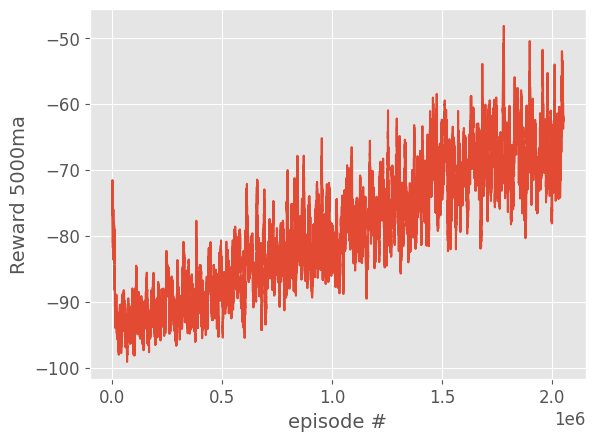

In [ ]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

In [ ]:
len(FRAMES)

255

In [ ]:
import matplotlib
#matplotlib.rcParams['animation.embed_limit'] = 2**128
plot_animation(FRAMES)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015


KeyboardInterrupt: ignored

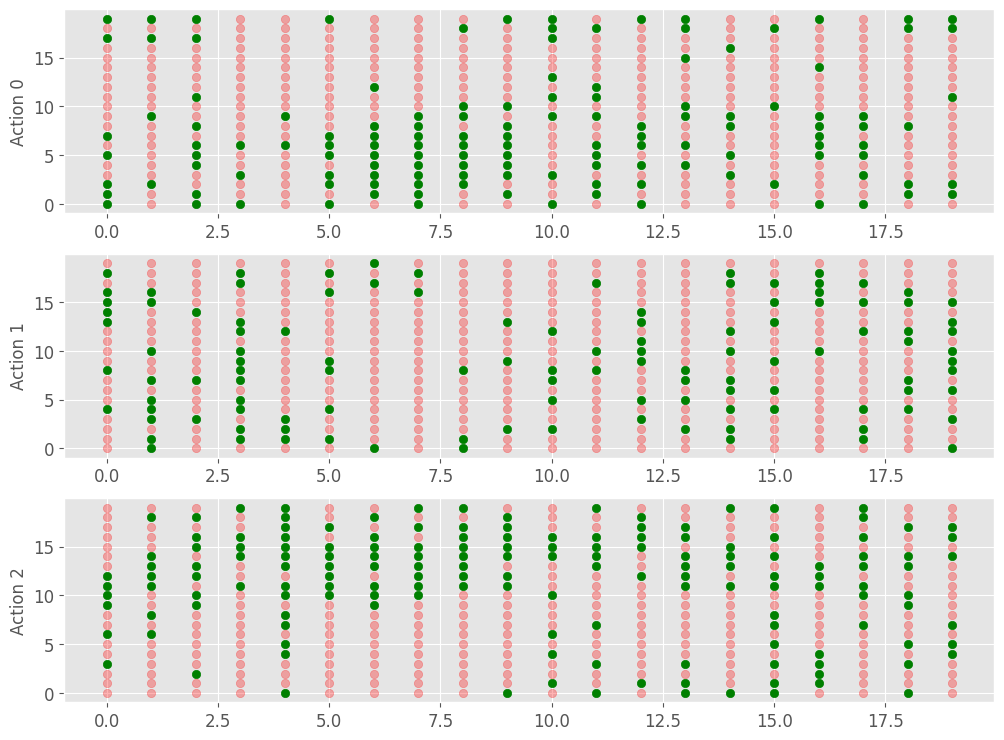

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')


def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    else:
        return "red", 0.3


fig = plt.figure(figsize=(12, 9))


for i in range(10001, 10900, 1):
    print(i)
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    q_table = np.load(f"qtables/{i}-qtable.npy")

    for x, x_vals in enumerate(q_table):
        for y, y_vals in enumerate(x_vals):
            ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
            ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
            ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

            ax1.set_ylabel("Action 0")
            ax2.set_ylabel("Action 1")
            ax3.set_ylabel("Action 2")

    #plt.show()
    plt.savefig(f"{i}.png")
    plt.clf()

In [ ]:
import cv2
import os


def make_video():
    # windows:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # Linux:
    #fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter('qlearn.avi', fourcc, 60.0, (1200, 900))

    for i in range(10001, 10034, 1):
        img_path = f"{i}.png"
        print(img_path)
        frame = cv2.imread(img_path)
        out.write(frame)

    out.release()


make_video()

# Q-Learning Create your own Enviroment with gym Tutorial


## Libraries - Setup

In [ ]:
import gym
import tensorflow as tf

from gym import Env
import random
from gym.spaces import Discrete, Box

try :
  # In Google Colab
  %tensorflow_version 2.x
except :
  pass

# Import Tensorflow
import tensorflow as tf

# Assure TensorFlow version >= 2 is installed. Otherwise install TensorFlow 2.0 version.
try :
  assert tf.__version__ >= "2.0"
  print ("TensorFlow version found:", tf.__version__)
except :
  !pip install tensorflow==2.4

# Import NumPy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version found: 2.12.0


In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!pip install keras
!pip install keras-rl2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

try:
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()
except ImportError:
    pass

## Enviroment Creation

In [ ]:
class ShowerEnv(Env):

  # in the initialization method we initialize:
  # our actions
  # observation space
  # our space
  # episode length
  def __init__(self):

    # actions we can take: down,stay,up
    self.action_space = Discrete(3)

    # Temperature array
    # we need it to see where our current temeprature is and how we can use it for our rewards,
    # and for how we will act next
    #self.low = np.array([self.min_position, -self.max_speed], dtype=np.float32)
    #self.high = np.array([self.max_position, self.max_speed], dtype=np.float32)
    self.low = np.array([1], dtype=np.float32)
    self.high = np.array([100], dtype=np.float32)
    self.observation_space = Box(self.low,self.high,dtype=np.float32)
    self.goal_position = 38

    # Set start temp
    self.state = 38 +random.randint(-3,3)

    # Set shower length
    # so the episode is 60
    self.shower_length = 60

  #what we do when we take actions
  def step(self, action):

    # Apply action
    # if the action is 0, we do 0-1 = -1 temperature
    # if the action is 1, we do 1-1 = 0 temperature
    # if the action is 2, we do 2-1 = 1 temperature

    self.state += action -1
    # reduce episode time by 1
    self.shower_length -=1

    # calculate reward
    if self.state >= 37 and self.state <= 39:
      reward = 1
    else:
      reward = -1

    # check if episode (shower in our case) is done
    if self.shower_length <= 0:
      done = True
    else:
      done = False

    # apply temperature noise , I believe it is for overfitting
    self.state += random.randint(-1,1)

    # set placeholder info ??
    info = {}

    # return step information
    return self.state, reward, done, info


  # for visualizations
  def render(self):
    # I should use the cv2 as I do at the second example
    return np.zeros([10])
  # here we reset our enviroment after it is done or after
  # each episode
  def reset(self):
    # set our variables at the initialized values
    self.state = 38 + random.randint(-3,3)
    self.shower_length = 60
    return self.state

In [ ]:
env = ShowerEnv()
env.reset()

39

In [ ]:
env.action_space.sample()# discrete it means we have a discrete actios like 0,1,2

0

In [ ]:
env.observation_space.sample() # Box means we we have something continuous

array([92.9591], dtype=float32)

## Q-Table Initialization and Q-Learning

In [ ]:
env.seed(42)
frames=[]

LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 20000

SHOW_FRAME = 5000
SAVE_QTABLE = 100
SHOW_EVERY = 500

DISCRETE_OS_SIZE=[20]*len(env.observation_space.high)
discrete_os_win_size= (env.observation_space.high - env.observation_space.low)/ DISCRETE_OS_SIZE

epsilon = 0.5
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2


epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

q_table = np.random.uniform(low=2,high=0,size=(DISCRETE_OS_SIZE + [env.action_space.n]))

ep_rewards = [] # the rewards of all the episodes
aggr_ep_rewards = { 'ep': [], 'avg': [], 'min': [], 'max': []}

def get_discrete_state(state):

  discrete_state = (state - env.observation_space.low) / discrete_os_win_size
  return tuple(discrete_state.astype(np.int))


for episode in range(EPISODES):

  episode_reward = 0

  discrete_state = get_discrete_state(env.reset())

  done=False

  while not done:

    if np.random.random() > epsilon:
      action = np.argmax(q_table[discrete_state])
    else:
      action = np.random.randint(0, env.action_space.n)

    new_state, reward, done, info = env.step(action)
    episode_reward += reward
    new_discrete_state = get_discrete_state(new_state)

    #print(reward,new_state)

    if not done:
      max_future_q = np.max(q_table[new_discrete_state])
      current_q = q_table[discrete_state + (action, )]

      new_q = (1-LEARNING_RATE)*current_q+LEARNING_RATE*(reward + DISCOUNT*max_future_q)

      q_table[discrete_state+(action, )] = new_q
    elif new_state >= env.goal_position:
      #print(f"We made it to the top at episode {episode}")
      q_table[discrete_state+ (action, )] = 0

    discrete_state = new_discrete_state

    #if episode % SHOW_FRAME == 0:
      #img = env.render(mode="rgb_array")
      #frames.append(env.render(mode ="rgb_array"))

  if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
    epsilon -= epsilon_decay_value

  ep_rewards.append(episode_reward)

  #if episode % SAVE_QTABLE:

   # np.save(f"qtables/{episode}-qtable.npy", q_table)


  if episode % SHOW_EVERY == 0:
    average_reward = sum(ep_rewards[-SHOW_EVERY:])/len(ep_rewards[-SHOW_EVERY:])
    aggr_ep_rewards['ep'].append(episode)
    aggr_ep_rewards['avg'].append(average_reward)
    aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
    aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))

    print(f"Episode: {episode}, avg: {average_reward}, min: {min(ep_rewards[-SHOW_EVERY:])}, max: {max(ep_rewards[-SHOW_EVERY:])}")




/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
<ipython-input-45-cdb797ee2671>:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


Episode: 0, avg: -42.0, min: -42, max: -42
Episode: 500, avg: -19.38, min: -60, max: 32
Episode: 1000, avg: -13.42, min: -60, max: 38
Episode: 1500, avg: -17.52, min: -60, max: 36
Episode: 2000, avg: -19.464, min: -60, max: 28
Episode: 2500, avg: -16.884, min: -60, max: 44
Episode: 3000, avg: -15.076, min: -60, max: 30
Episode: 3500, avg: -14.86, min: -60, max: 34
Episode: 4000, avg: -10.16, min: -60, max: 44
Episode: 4500, avg: -12.288, min: -60, max: 38
Episode: 5000, avg: -11.824, min: -60, max: 40
Episode: 5500, avg: -12.048, min: -60, max: 36
Episode: 6000, avg: -10.568, min: -60, max: 40
Episode: 6500, avg: -8.916, min: -58, max: 52
Episode: 7000, avg: -8.624, min: -60, max: 42
Episode: 7500, avg: -6.852, min: -60, max: 44
Episode: 8000, avg: -4.872, min: -60, max: 42
Episode: 8500, avg: -2.772, min: -60, max: 44
Episode: 9000, avg: -3.54, min: -60, max: 50
Episode: 9500, avg: 2.308, min: -60, max: 46
Episode: 10000, avg: 7.496, min: -60, max: 46
Episode: 10500, avg: 9.864, min: 

In [ ]:
len(frames)

0

## Plots and Results

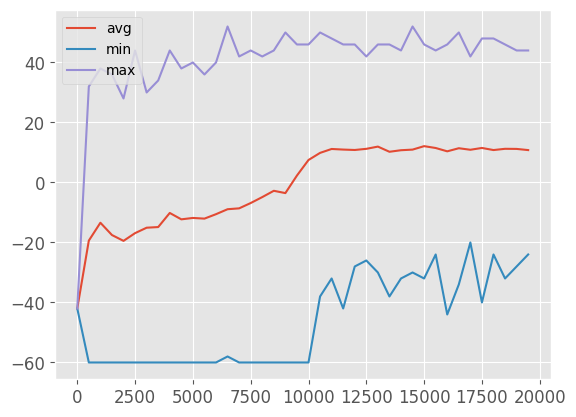

In [ ]:
#plt.figure(figsize=(10,7))
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="avg")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max")
plt.legend(loc=2 )
plt.show()

In [ ]:
plot_animation(frames)

IndexError: ignored

<Figure size 640x480 with 0 Axes>

# Rofos Custom Enviroment with Open AI gym

## Libraries - Setup

In [ ]:
import gym
try :
  # In Google Colab
  %tensorflow_version 2.x
except :
  pass

# Import Tensorflow
import tensorflow as tf

# Assure TensorFlow version >= 2 is installed. Otherwise install TensorFlow 2.0 version.
try :
  assert tf.__version__ >= "2.0"
  print ("TensorFlow version found:", tf.__version__)
except :
  !pip install tensorflow==2.4

# Import NumPy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version found: 2.12.0


In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1

In [ ]:
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

try:
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()
except ImportError:
    pass

## Plots, Frame and Animations Functions

In [ ]:
# Creates an image for the environment
def plot_environment(env, figsize = (5,4)):
    plt.figure( figsize = figsize)
    img = env.render(mode = "rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [ ]:
#Stores all the images to create an animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
def polar_frames(r,theta,rticks=[0],rlabel=-90,grid=False):

  FRAMES = []
  fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
  for i in range(len(r)):

    ax.plot(theta[:i], r[:i],color='black')
    ax.set_theta_zero_location('N')
    ax.set_rmax(max(r))
    #ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    #ax.set_rticks(rticks)  # Less radial ticks
    ax.set_rlabel_position(rlabel)  # Move radial labels away from plotted line
    ax.grid(grid)
    #ax.axos
    plt.axis("off")
    plt.savefig("course{}.png".format(i))
    img = Image.open("course{}.png".format(i))
    FRAMES.append(img)
    #ax.set_title("A line plot on a polar axis", va='bottom')
    #plt.show()
  return FRAMES

## Create Enviroment

the sensors are on the sail, so if the sail has an angle it is not oriented on the real north

In [ ]:
class wind_sensor():
  def __init__(self):
    self.wind_direciton = random.randint(0,15)
    self.wind_speed = 10
  def get_data(self):
    return self.wind_direction , self.wind_speed

The acceleromtere return data in cartesian coordinates, we want t convert them to polar, so we will have the acceleration of the magnitude and the angle acceleration as well. I suppose


απο το αξελερομετρο μαθαινω σχετικη επιταχυνση

radio frequences


In [ ]:
class accelerometer_sensor():
  def __init__(self):
    self.x = random.randint(0,15)
    self.y = 10
    self.r=np.sqrt(self.x**2 + self.y**2)
    self.theta = np.atan2(self.x,self.y)
  def get_data(self):
    return self.r , self.theta

In [ ]:
class gps_sensor():
  def __init__(self):
    self.x = 0
    self.y = 0
    self.r=np.sqrt(self.x**2 + self.y**2)
    self.theta = np.atan2(self.x,self.y)
  def get_data(self):
    return self.r , self.theta

εισαι σε αυτο το xy  και θες να πας σε αυτο το xy, βγαλε διανυσμα, και τσεκαρε που ειναι πως ερχεται ο αερας για να καταλαβει πως θα παει


from gyroscope maybe we learn what is our boats angle

In [ ]:
class gyroscope_sensor():
  def __init__(self):
    self.gx = 0
    self.gy = 0
  def get_data(self):
    return self.gx ,  self.gy

In [ ]:
import gym
import numpy as np
import tensorflow as tf
#import pybullet as p

class SailingEnv(gym.Env):
    def __init__(self):
        # Define observation space and action space
        # we have 5 sensors and different kind of variables
        # so we need to have 5 keys at our observation space dictionary
        # for now the gyroscope will stay in comments because it will be easier
        # and because for now I will try 2D grid
        #self.boat_length = 2
        self.trip_time = 200
        self.wind_sensor = wind_sensor()
        self.accelerometer_sensor = accelerometer_sensor()
        self.gps_sensor = gps_sensor()
        self.min_theta = 0
        self.max_theta = 360
        self.max_r = 5
        self.goal_position = np.array([0],[self.max_r])
        self.accelerometer_limit = 10
        self.gyroscope_limit = 360
        self.observation_space = gym.spaces.Dict({
            'wind_speed': gym.spaces.Box(low=0, high=70, shape=()),
            'wind_direction': gym.spaces.Box(low=0, high=15, shape=()),
            'accelerometer_data': gym.spaces.Box(low = self.accelerometer_limit, high = self.accelerometer_limit, shape=(2,)),# shape 2 for now , cause of 2D
            'gyroscope_data': gym.spaces.Box(low=-self.gyroscope_limit, high=self.gyroscope_limit, shape=(2,))
            'gps_data': gym.spaces.Box(low=np.array([self.min_theta,-self.max_r]), high=np.array([self.max_theta,self.max_r]))
        })
        #self.goal_position :
        self.action_space = gym.spaces.Dict({
            'sails_angle': gym.spaces.Discrete(90),
            'wheel_angle': gym.spaces.Discrete(90)
        })

        self.state = np.array([0],[0],)

        # Initialize sensors
        #self.wind_sensor = WindSensor()
        #self.accelerometer_sensor = AccelerometerSensor()
        #self.gyroscope_sensor = GyroscopeSensor()
        #self.gps_sensor = GpsSensor()

    def reset(self):
        wind_speed, wind_direction = self.wind_sensor.get_data()
        accelerometer_data = self.accelerometer_sensor.get_data()
        #gyroscope_data = self.gyroscope_sensor.get_data()
        gps_data = self.gps_sensor.get_data()

        return {
            'wind_speed': wind_speed,
            'wind_direction': wind_direction,
            'accelerometer_data': accelerometer_data,
            #'gyroscope_data': gyroscope_data,
            'gps_data': gps_data
        }

    def step(self, action):

        wind_speed, wind_direction = self.wind_sensor.get_data()
        accelerometer_data = self.accelerometer_sensor.get_data()
        #gyroscope_data = self.gyroscope_sensor.get_data()
        gps_data = self.gps_sensor.get_data()
        state = {
            'wind_speed': wind_speed,
            'wind_direction': wind_direction,
            'accelerometer_data': accelerometer_data,
            #'gyroscope_data': gyroscope_data,
            'gps_data': gps_data
        }
        # do the calculations about how the variables will now
        # be converted to from the previous state and the action

        next_state, done = self.transition_function(state, action)
        reward = 100*(self.observation_space['gps_data'][0]/self.goal_position[0])*(self.observation_space['gps_data'][1] / self.goal_position[1])
        info = {}
        return next_state, reward, done, info

    def render(self, mode='human'):
      return self.observation_space['gps_data']
    def close(self):
        # TODO: Clean up simulation resources


## Plots and Results

In [ ]:
import matplotlib.pyplot as plt

# Plot polar grid
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.set_theta_zero_location('N')
#ax.set_theta_direction(-1)
#ax.set_rlim(r_min, r_max)
#ax.set_rticks(r_values)
ax.grid(True)

# Plot grid points



r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r

#ax.scatter(theta_grid.flatten(), r_grid.flatten(), s=10, c='black')
#ax.scatter(100,np.pi/2,s=10,c='blue')
ax.plot(r,theta)
# Show plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
FRAMES = []

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for i in range(len(r)):

  ax.plot(theta[:i], r[:i],color='black')
  ax.set_theta_zero_location('N')
  ax.set_rmax(2)
  ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
  ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
  ax.grid(True)

  plt.savefig("course{}.png".format(i))
  img = Image.open("course{}.png".format(i))
  FRAMES.append(img)
  #ax.set_title("A line plot on a polar axis", va='bottom')
  #plt.show()

In [ ]:
def polar_frames(r,theta,rticks=[0],rlabel=-90,grid=False):

  FRAMES = []
  fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
  for i in range(len(r)):

    ax.plot(theta[:i], r[:i],color='black')
    ax.set_theta_zero_location('N')
    ax.set_rmax(max(r))
    #ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    #ax.set_rticks(rticks)  # Less radial ticks
    ax.set_rlabel_position(rlabel)  # Move radial labels away from plotted line
    ax.grid(grid)
    #ax.axos
    plt.axis("off")
    plt.savefig("course{}.png".format(i))
    img = Image.open("course{}.png".format(i))
    FRAMES.append(img)
    #ax.set_title("A line plot on a polar axis", va='bottom')
    #plt.show()
  return FRAMES

In [ ]:
r = np.arange(0, 1, 0.01)
theta = 2 * np.pi * r
FRAMES = polar_frames(r,theta)

In [ ]:
plot_animation(FRAMES)

In [ ]:
#r = np.arange(0, 1, 0.01)
theta = np.radians(np.arange(0,360,1))
r=2-2*np.cos(theta)
FRAMES = polar_frames(r,theta)

In [ ]:
plot_animation(FRAMES)

# Rofos Custom Envriroment 1 (works)  

## Libraries - Setup

In [ ]:
import gym
try :
  # In Google Colab
  %tensorflow_version 2.x
except :
  pass

# Import Tensorflow
import tensorflow as tf

# Assure TensorFlow version >= 2 is installed. Otherwise install TensorFlow 2.0 version.
try :
  assert tf.__version__ >= "2.0"
  print ("TensorFlow version found:", tf.__version__)
except :
  !pip install tensorflow==2.4

# Import NumPy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import pickle
from matplotlib import style
import time
from PIL import Image

style.use("ggplot")
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version found: 2.12.0


In [ ]:
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

try:
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()
except ImportError:
    pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Plots and Animations Functions

In [ ]:
# Creates an image for the environment
def plot_environment(env, figsize = (5,4)):
    plt.figure( figsize = figsize)
    img = env.render(mode = "rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [ ]:
#Stores all the images to create an animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

## Create Environment

First we define our variables for our enviroment and for our Q-learning

In [ ]:
SIZE = 30
HM_EPISODES = 300000
MOVE_PENALTY = 1
# HIT_PENALTY = 300
BOUNDARY_PENALTY = 10
GOAL_REWARD = 1000
episode_rewards = []
FRAMES = []
epsilon =0.9
EPS_DECAY = 0.9998

SHOW_EVERY = 30000
SHOW_FRAMES = 30000
SHOW_QTABLE = 200

start_q_table = None # or filename so we would take an already q table

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1
GOAL_N = 2
OTHER_N = 3

d = {1: (255,175,0), 2: (0,255,0),3: (0,0,255)}

In [ ]:
def wind_direction_sensor(x,y):
  directions = np.ones((20,20))
  directions = 8*directions #to come from north
  angles = {0:90,1:77.5,2:45,3:22.5,4:0,5:337.5,6:315,7:292.5,8:270,9:247.5,10:225,11:202.5,12:180,13:157.5,14:135,15:112.5}

  return angles[directions[x,y]]

Now we will create our boat class for the example with the idea that the wind comes from the north and is steady everywhere


In [ ]:
class Boat:
  def __init__(self):
    # self.x = np.random.randint(0,SIZE)
    # self.y = np.random.randint(0,SIZE)
      self.x = 15
      self.y = 10
      self.rudder = 270
      self.sail = 270

  def __str__(self):
    return f"{self.x}, {self.y}"

  def __sub__(self, other):
    return (self.x - other.x,self.y - other.y)

  def action(self, rudder_angle, sail_angle):
    # wind_dir  = wind_direction_sensor(self.x,self.y)

############################################
##### the angle of the rudder is 0 degrees
############################################

    if rudder_angle == 0: #angle 0
      if sail_angle == 0: #angle 0
        self.move(x = 0 , y = -3)
      elif sail_angle == 1: #angle -30 (330)
        self.move(x = 0, y = -2)
      elif sail_angle == 2: #angle -60 (300)
        self.move(x = 0 , y = -1)
      elif sail_angle == 3: #angle -90 (270)
        self.move(x = 0, y = 0)
      elif sail_angle == 4: #angle -120 (240)
        self.move(x = 0 , y = -1)
      elif sail_angle == 5: #angle -150 (210)
        self.move(x = 0, y = -2)
      elif sail_angle == 6: #angle 180
        self.move(x = 0 , y = -3)

############################################
##### the angle of the rudder is 45 degrees
############################################

    elif rudder_angle == 1: #angle 45
      if sail_angle == 0: #angle 0
        self.move(x = -2 , y = -2)
      elif sail_angle == 1: #angle -30 (330)
        self.move(x = -1, y = -1)
      elif sail_angle == 2: #angle -60 (300)
        self.move(x = 1 , y = 1)
      elif sail_angle == 3: #angle -90 (270)
        self.move(x = 1, y = 1)
      elif sail_angle == 4: #angle -120 (240)
        self.move(x = 2 , y = 2)
      elif sail_angle == 5: #angle -150 (210)
        self.move(x = -2, y = -2)
      elif sail_angle == 6: #angle 180
        self.move(x = -2 , y = -2)

############################################
##### the angle of the rudder is -45 degrees
############################################
    elif rudder_angle == 2: #angle 45
      if sail_angle == 0: #angle 0
        self.move(x = -2 , y = -2)
      elif sail_angle == 1: #angle -30 (330)
        self.move(x = -2, y = -2)
      elif sail_angle == 2: #angle -60 (300)
        self.move(x = 2 , y = 2)
      elif sail_angle == 3: #angle -90 (270)
        self.move(x = 1, y = 1)
      elif sail_angle == 4: #angle -120 (240)
        self.move(x = 1 , y = 1)
      elif sail_angle == 5: #angle -150 (210)
        self.move(x = -1, y = -1)
      elif sail_angle == 6: #angle 180
        self.move(x = -2 , y = -2)

  def move(self,x=False,y=False):
    if not x:
      self.x += np.random.randint(-1,2)
    else:
      self.x += x
    if not y:
      self.y += np.random.randint(-1,2)
    else:
      self.y += y

    if self.x < 0:
      self.x = 0
    elif self.x > SIZE-1:
      self.x = SIZE-1

    if self.y < 0:
      self.y = 0
    elif self.y > SIZE-1:
      self.y = SIZE-1

if start_q_table is None:
  q_table = {}
  for x1 in range(-SIZE+1,SIZE):
      for y1 in range(-SIZE+1,SIZE):
                q_table[(x1,y1)] = [[np.random.uniform(-4,0) for i in range(3)],[np.random.uniform(-8,0) for i in range(7)]]
else:
  with open(start_qtable, "rb") as f:
    q_table = pickle.load(f)

## Q-Table Initialization and Q-Learning

In [ ]:
for episode in range(HM_EPISODES):
  player = Boat()
  GOAL = Boat()
  GOAL.y = 25

  if episode % SHOW_EVERY == 0:
    print(f"on # {episode}, epsilon:{epsilon}")
    print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
    show = True
  else:
    show = False

  episode_reward = 0
  for i in range(200):
    obs = (player-GOAL)
    if np.random.random() > epsilon:
      actions = [np.argmax(q_table[obs][0]),np.argmax(q_table[obs][1])]

    else:
      actions = [np.random.randint(0,3),np.random.randint(0,7)]
    player.action(actions[0],actions[1])

    if player.x == 30 or player.y == 30:
      reward = -BOUNDARY_PENALTY

    elif player.x == GOAL.x and player.y == GOAL.y:
      reward = GOAL_REWARD
    else:
      reward = -MOVE_PENALTY
###quicksave
    new_obs = (player - GOAL)
    max_future_q0 = np.max(q_table[new_obs][0][actions[0]])
    max_future_q1 = np.max(q_table[new_obs][1][actions[1]])

    current_q0 = q_table[obs][0][actions[0]]
    current_q1 = q_table[obs][1][actions[1]]

    if reward == GOAL_REWARD:
      new_q = GOAL_REWARD
    if reward == BOUNDARY_PENALTY:
      new_q = -BOUNDARY_PENALTY
    else:
      new_q0 = (1-LEARNING_RATE)*current_q0 + LEARNING_RATE * (reward + DISCOUNT*max_future_q0)
      new_q1 = (1-LEARNING_RATE)*current_q1 + LEARNING_RATE * (reward + DISCOUNT*max_future_q1)

    q_table[obs][0][actions[0]] = new_q0
    q_table[obs][1][actions[1]] = new_q1

    if episode % SHOW_FRAMES == 0:
      env = np.zeros((SIZE,SIZE, 3),dtype = np.uint8)
      env[GOAL.y][GOAL.x] = d[GOAL_N]
      env[player.y][player.x] = d[PLAYER_N]

      img = Image.fromarray(env, "RGB")
      img = img.resize((300,300))

      FRAMES.append(img)
      if reward == GOAL_REWARD or reward == -BOUNDARY_PENALTY:
        break

    episode_reward += reward
    if reward == GOAL_REWARD or reward == -BOUNDARY_PENALTY:
      break

    epsilon *= EPS_DECAY
    episode_rewards.append(episode_reward)



on # 0, epsilon:0.9
30000 ep mean nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on # 30000, epsilon:1.235e-320
30000 ep mean -86.67516666666667
on # 60000, epsilon:1.235e-320
30000 ep mean -84.52476666666666
on # 90000, epsilon:1.235e-320
30000 ep mean -86.09396666666666
on # 120000, epsilon:1.235e-320
30000 ep mean -84.55473333333333
on # 150000, epsilon:1.235e-320
30000 ep mean -84.77466666666666
on # 180000, epsilon:1.235e-320
30000 ep mean -82.84113333333333
on # 210000, epsilon:1.235e-320
30000 ep mean -86.28156666666666
on # 240000, epsilon:1.235e-320
30000 ep mean -84.88043333333333
on # 270000, epsilon:1.235e-320
30000 ep mean -85.07646666666666


In [ ]:
with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

## Plots and Results

In [ ]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

KeyboardInterrupt: ignored

In [ ]:
len(FRAMES)

In [ ]:
import matplotlib
plot_animation(FRAMES)

# Rofos Custom Envriroment 1 revison change angle penalty

## Libraries - Setup

In [ ]:
import gym
try :
  # In Google Colab
  %tensorflow_version 2.x
except :
  pass

# Import Tensorflow
import tensorflow as tf

# Assure TensorFlow version >= 2 is installed. Otherwise install TensorFlow 2.0 version.
try :
  assert tf.__version__ >= "2.0"
  print ("TensorFlow version found:", tf.__version__)
except :
  !pip install tensorflow==2.4

# Import NumPy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import pickle
from matplotlib import style
import time
from PIL import Image

style.use("ggplot")
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version found: 2.12.0


In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

try:
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()
except ImportError:
    pass

## Plots and Animations Functions

In [ ]:
# Creates an image for the environment
def plot_environment(env, figsize = (5,4)):
    plt.figure( figsize = figsize)
    img = env.render(mode = "rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [ ]:
#Stores all the images to create an animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

## Create Environment

First we define our variables for our enviroment and for our Q-learning

In [ ]:
SIZE = 30
HM_EPISODES = 100000
MOVE_PENALTY = 1
# HIT_PENALTY = 300
BOUNDARY_PENALTY = 10
TURN_PENALTY = 3
GOAL_REWARD = 1000
episode_rewards = []
FRAMES = []
epsilon =0.9
EPS_DECAY = 0.9998
ACT = 0
SHOW_EVERY = 20000
SHOW_FRAMES = 20000
SHOW_QTABLE = 200
q_table_checkpoint = 0
reward_checkpoint = -100000
start_q_table = None # or filename so we would take an already q table

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1
GOAL_N = 2
OTHER_N = 3

d = {1: (255,175,0), 2: (0,255,0),3: (0,0,255)}

In [ ]:
def wind_direction_sensor(x,y):
  directions = np.ones((20,20))
  directions = 8*directions #to come from north
  angles = {0:90,1:77.5,2:45,3:22.5,4:0,5:337.5,6:315,7:292.5,8:270,9:247.5,10:225,11:202.5,12:180,13:157.5,14:135,15:112.5}

  return angles[directions[x,y]]

Now we will create our boat class for the example with the idea that the wind comes from the north and is steady everywhere


In [ ]:
class Boat:
  def __init__(self):
    # self.x = np.random.randint(0,SIZE)
    # self.y = np.random.randint(0,SIZE)
      self.x = 15
      self.y = 10
      self.rudder = 270
      self.sail = 270

  def __str__(self):
    return f"{self.x}, {self.y}"

  def __sub__(self, other):
    return (self.x - other.x,self.y - other.y)

  def action(self, rudder_angle, sail_angle):
    # wind_dir  = wind_direction_sensor(self.x,self.y)

############################################
##### the angle of the rudder is 0 degrees
############################################

    if rudder_angle == 0: #angle 0
      if sail_angle == 0: #angle 0
        self.move(x = 0 , y = -3)
      elif sail_angle == 1: #angle -30 (330)
        self.move(x = 0, y = -2)
      elif sail_angle == 2: #angle -60 (300)
        self.move(x = 0 , y = -1)
      elif sail_angle == 3: #angle -90 (270)
        self.move(x = 0, y = 0)
      elif sail_angle == 4: #angle -120 (240)
        self.move(x = 0 , y = -1)
      elif sail_angle == 5: #angle -150 (210)
        self.move(x = 0, y = -2)
      elif sail_angle == 6: #angle 180
        self.move(x = 0 , y = -3)

############################################
##### the angle of the rudder is 45 degrees
############################################

    elif rudder_angle == 1: #angle 45
      if sail_angle == 0: #angle 0
        self.move(x = -2 , y = -2)
      elif sail_angle == 1: #angle -30 (330)
        self.move(x = -1, y = -1)
      elif sail_angle == 2: #angle -60 (300)
        self.move(x = 1 , y = 1)
      elif sail_angle == 3: #angle -90 (270)
        self.move(x = 1, y = 1)
      elif sail_angle == 4: #angle -120 (240)
        self.move(x = 2 , y = 2)
      elif sail_angle == 5: #angle -150 (210)
        self.move(x = -2, y = -2)
      elif sail_angle == 6: #angle 180
        self.move(x = -2 , y = -2)

############################################
##### the angle of the rudder is -45 degrees
############################################
    elif rudder_angle == 2: #angle 45
      if sail_angle == 0: #angle 0
        self.move(x = -2 , y = -2)
      elif sail_angle == 1: #angle -30 (330)
        self.move(x = -2, y = -2)
      elif sail_angle == 2: #angle -60 (300)
        self.move(x = 2 , y = 2)
      elif sail_angle == 3: #angle -90 (270)
        self.move(x = 1, y = 1)
      elif sail_angle == 4: #angle -120 (240)
        self.move(x = 1 , y = 1)
      elif sail_angle == 5: #angle -150 (210)
        self.move(x = -1, y = -1)
      elif sail_angle == 6: #angle 180
        self.move(x = -2 , y = -2)

  def move(self,x=False,y=False):
    if not x:
      self.x += np.random.randint(-1,2)
    else:
      self.x += x
    if not y:
      self.y += np.random.randint(-1,2)
    else:
      self.y += y

    if self.x < 0:
      self.x = 0
    elif self.x > SIZE-1:
      self.x = SIZE-1

    if self.y < 0:
      self.y = 0
    elif self.y > SIZE-1:
      self.y = SIZE-1

if start_q_table is None:
  q_table = {}
  for x1 in range(-SIZE+1,SIZE):
      for y1 in range(-SIZE+1,SIZE):
                q_table[(x1,y1)] = [[np.random.uniform(-4,0) for i in range(3)],[np.random.uniform(-8,0) for i in range(7)]]
else:
  with open(start_qtable, "rb") as f:
    q_table = pickle.load(f)

## Q-Table Initialization and Q-Learning

In [ ]:
from numba import njit

In [ ]:
%%time
for episode in range(HM_EPISODES):
  player = Boat()
  GOAL = Boat()
  GOAL.y = 25

  if episode % SHOW_EVERY == 0:
    print(f"on # {episode}, epsilon:{epsilon}")
    print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
    show = True
  else:
    show = False

  episode_reward = 0
  for i in range(200):
    obs = (player-GOAL)
    if np.random.random() > epsilon:
      actions = [np.argmax(q_table[obs][0]),np.argmax(q_table[obs][1])]

    else:
      actions = [np.random.randint(0,3),np.random.randint(0,7)]
    player.action(actions[0],actions[1])

    if ACT == 0:
      ACT = actions
    else:
      if ACT != actions:
        reward = -TURN_PENALTY
        ACT = actions
    # if player.x == 0 or player.x == 30: #or player.y == 0:
    #   reward = -BOUNDARY_PENALTY
    if player.x == GOAL.x and player.y == GOAL.y:

    # elif player.x == GOAL.x and player.y == GOAL.y:
      reward = GOAL_REWARD
    else:
      reward = -MOVE_PENALTY
###quicksave
    new_obs = (player - GOAL)
    max_future_q0 = np.max(q_table[new_obs][0][actions[0]])
    max_future_q1 = np.max(q_table[new_obs][1][actions[1]])

    current_q0 = q_table[obs][0][actions[0]]
    current_q1 = q_table[obs][1][actions[1]]

    if reward == GOAL_REWARD:
      new_q = GOAL_REWARD
    if reward == BOUNDARY_PENALTY:
      new_q = -BOUNDARY_PENALTY
    else:
      new_q0 = (1-LEARNING_RATE)*current_q0 + LEARNING_RATE * (reward + DISCOUNT*max_future_q0)
      new_q1 = (1-LEARNING_RATE)*current_q1 + LEARNING_RATE * (reward + DISCOUNT*max_future_q1)

    q_table[obs][0][actions[0]] = new_q0
    q_table[obs][1][actions[1]] = new_q1

    if episode % SHOW_FRAMES == 0:
      env = np.zeros((SIZE,SIZE, 3),dtype = np.uint8)
      env[GOAL.y][GOAL.x] = d[GOAL_N]
      env[player.y][player.x] = d[PLAYER_N]

      img = Image.fromarray(env, "RGB")
      img = img.resize((300,300))

      FRAMES.append(img)
      if reward == GOAL_REWARD: #or reward == -BOUNDARY_PENALTY:
        break

    episode_reward += reward

    if reward_checkpoint < reward:
      reward_checkpoint = reward
      q_table_checkpoint = q_table

    if reward == GOAL_REWARD: #or reward == -BOUNDARY_PENALTY:
      break


    epsilon *= EPS_DECAY
    episode_rewards.append(episode_reward)



on # 0, epsilon:0.9
20000 ep mean nan
on # 20000, epsilon:1.235e-320
20000 ep mean -85.9151
on # 40000, epsilon:1.235e-320
20000 ep mean -81.85145
on # 60000, epsilon:1.235e-320
20000 ep mean -81.45355
on # 80000, epsilon:1.235e-320
20000 ep mean -81.03525
CPU times: user 12min 11s, sys: 16.7 s, total: 12min 28s
Wall time: 12min 22s


In [ ]:
with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

## Plots and Results

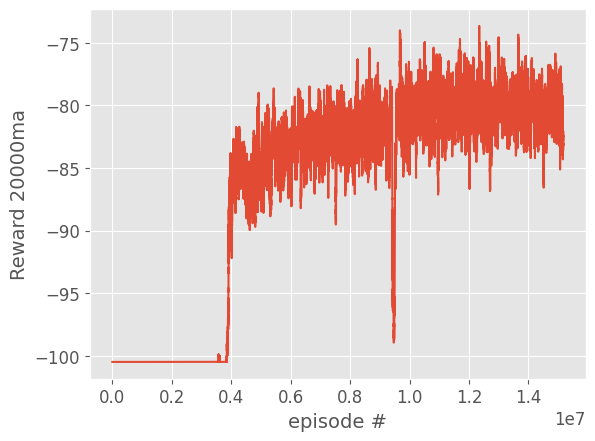

In [ ]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

In [ ]:
len(FRAMES)

785

In [ ]:
import matplotlib
#matplotlib.rcParams['animation.embed_limit'] = 2**128
plot_animation(FRAMES)

# Rofos Custom Envriroment 2

## Libraries - Setup

In [ ]:
import gym
try :
  # In Google Colab
  %tensorflow_version 2.x
except :
  pass

# Import Tensorflow
import tensorflow as tf

# Assure TensorFlow version >= 2 is installed. Otherwise install TensorFlow 2.0 version.
try :
  assert tf.__version__ >= "2.0"
  print ("TensorFlow version found:", tf.__version__)
except :
  !pip install tensorflow==2.4

# Import NumPy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import pickle
from matplotlib import style
import time
from PIL import Image

style.use("ggplot")
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version found: 2.12.0


In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

try:
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()
except ImportError:
    pass

## Plots and Animations Functions

In [ ]:
# Creates an image for the environment
def plot_environment(env, figsize = (5,4)):
    plt.figure( figsize = figsize)
    img = env.render(mode = "rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Stores all the images to create an animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

## Create Environment

First we define our variables for our enviroment and for our Q-learning

In [ ]:
SIZE = 20
HM_EPISODES = 25000
MOVE_PENALTY = 1
# HIT_PENALTY = 300
GOAL_REWARD = 1000
episode_rewards = []
FRAMES = []
epsilon =0.9
EPS_DECAY = 0.9998

SHOW_EVERY = 5000
SHOW_FRAMES = 5000
SHOW_QTABLE = 200

start_q_table = None # or filename so we would take an already q table

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1
GOAL_N = 2
OTHER_N = 3

d = {1: (255,175,0), 2: (0,255,0),3: (0,0,255)}

In [ ]:
def wind_direction_sensor(x,y):
  directions = np.ones((20,20))
  directions = 8*directions #to come from north
  angles = {0:90,1:77.5,2:45,3:22.5,4:0,5:337.5,6:315,7:292.5,8:270,9:247.5,10:225,11:202.5,12:180,13:157.5,14:135,15:112.5}

  return angles[directions[x,y]]

Now we will create our boat class for the example with the idea that the wind comes from the north and is steady everywhere


In [ ]:
class Boat:
  def __init__(self):
    # self.x = np.random.randint(0,SIZE)
    # self.y = np.random.randint(0,SIZE)
      self.rho = 0
      self.theta = 90
      self.rudder = 270
      self.sail = 270

  def __str__(self):
    return f"{self.x}, {self.y}"

  def __sub__(self, other):
    return (self.x - other.x,self.y - other.y)

  def action(self, rudder_angle, sail_angle):
    # wind_dir  = wind_direction_sensor(self.x,self.y)

    if runder_angle == 0: #angle 0
      if sail_angle == 0: #angle 0
        self.move(x = 0 , y = -1)
      elif sail_angle == 1: #angle 30
        self.move(x = )


    elif runder_angle == 1: # angle 45

    elif runder_angle == 2: # angle -45

  def move(self,x=False,y=False):
    if not x:
      self.x += np.random.radnint(-1,2)
    else:
      self.x += x
    if not y:
      self.y += np.random.radnint(-1,2)
    else:
      self.y += y

    if self.x < 0:
      self.x = 0
    elif self.x > SIZE-1:
      self.x = SIZE-1

    if self.y < 0:
      self.y = 0
    elif self.y > SIZE-1:
      self.y = SIZE-1

if start_q_table is None:
  q_table = {}
  for x1 in range(-SIZE+1,SIZE):
      for y1 in range(-SIZE+1,SIZE):
          for x2 in range(-SIZE+1,SIZE):
              for y2 in range(-SIZE+1,SIZE):
                q_table[((x1,y1),(x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]
else:
  with open(start_qtable, "rb") as f:
    q_table = pickle.load(f)

## Q-Table Initialization and Q-Learning

In [ ]:
for episode in range(HM_EPISODES):
  player = Boat()
  food = Boat()
  # enemy = Boat()

  if episode % SHOW_EVERY == 0:
    print(f"on # {episode}, epsilon:{epsilon}")
    print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
    show = True
  else:
    show = False

  episode_reward = 0
  for i in range(200):
    obs = (player-food)
    if np.random.random() > epsilon:
      action = np.argmax(q_table[obs])
    else:
      action = np.random.randint(0,4)
    player.action(action)

    ### maybe later
    #food.move()
    #enemy.move
    ###

    if player.x == enemy.x and player.y == enemy.y:
      reward = -ENEMY_PENALTY

    elif player.x == food.x and player.y == food.y:
      reward = FOOD_REWARD
    else:
      reward = -MOVE_PENALTY

    new_obs = (player - food, player - enemy)
    max_future_q = np.max(q_table[new_obs])
    current_q = q_table[obs][action]

    if reward == FOOD_REWARD:
      new_q = FOOD_REWARD
    if reward == ENEMY_PENALTY:
      new_q = -ENEMY_PENALTY
    else:
      new_q = (1-LEARNING_RATE)*current_q + LEARNING_RATE * (reward + DISCOUNT*max_future_q)

    q_table[obs][action] = new_q

    if episode % SHOW_FRAMES == 0:
      env = np.zeros((SIZE,SIZE, 3),dtype = np.uint8)
      env[food.y][food.x] = d[FOOD_N]
      env[player.y][player.x] = d[PLAYER_N]
      env[enemy.y][enemy.x] = d[ENEMY_N]

      img = Image.fromarray(env, "RGB")
      img = img.resize((300,300))
      #cv2.imshow("", np.array(img))
      #cv2_imshow(np.array(img))
      FRAMES.append(img)
      if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
        break
      if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
        if cv2.waitKey(500) & 0xFF == ord("q"):
          break
      if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
        if cv2.waitKey(1) & 0xFF == ord("q"):
          break

    episode_reward += reward
    if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
      break

    #if episode % SHOW_EVERY == 0:
     # env = 255*np.ones((SIZE,SIZE, 3))
      #img = Image.fromarray(env, "RGB")
      #FRAMES.append(img)


    epsilon *= EPS_DECAY
    episode_rewards.append(episode_reward)



on # 0, epsilon:0.9
5000 ep mean nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on # 5000, epsilon:1.766539237150882e-55
5000 ep mean -86.5222
on # 10000, epsilon:8.764684082790181e-96
5000 ep mean -68.4704
on # 15000, epsilon:6.792467427283521e-129
5000 ep mean -74.0372
on # 20000, epsilon:2.468815677850986e-155
5000 ep mean -65.3566


In [ ]:
with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

## Plots and Results

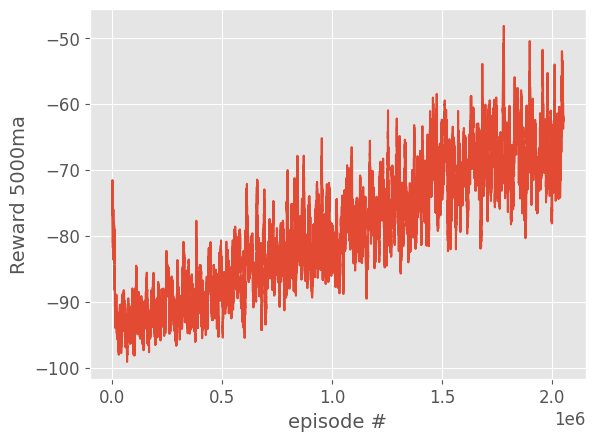

In [ ]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

In [ ]:
len(FRAMES)

255

In [ ]:
import matplotlib
#matplotlib.rcParams['animation.embed_limit'] = 2**128
plot_animation(FRAMES)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015


KeyboardInterrupt: ignored

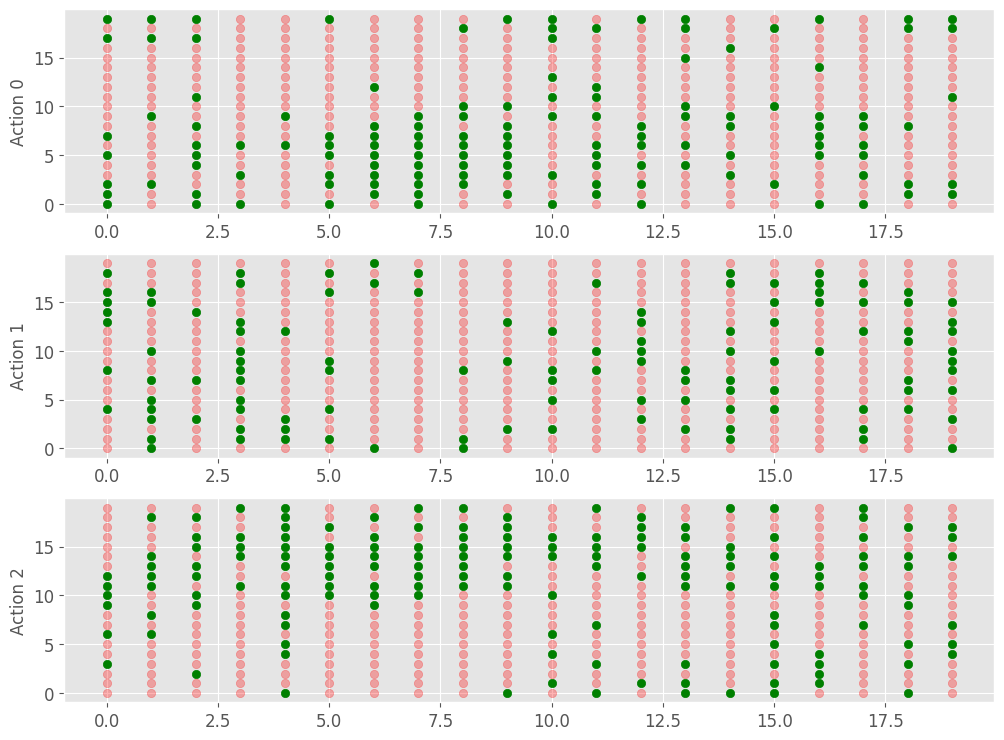

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')


def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    else:
        return "red", 0.3


fig = plt.figure(figsize=(12, 9))


for i in range(10001, 10900, 1):
    print(i)
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    q_table = np.load(f"qtables/{i}-qtable.npy")

    for x, x_vals in enumerate(q_table):
        for y, y_vals in enumerate(x_vals):
            ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
            ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
            ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

            ax1.set_ylabel("Action 0")
            ax2.set_ylabel("Action 1")
            ax3.set_ylabel("Action 2")

    #plt.show()
    plt.savefig(f"{i}.png")
    plt.clf()

In [ ]:
import cv2
import os


def make_video():
    # windows:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # Linux:
    #fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter('qlearn.avi', fourcc, 60.0, (1200, 900))

    for i in range(10001, 10034, 1):
        img_path = f"{i}.png"
        print(img_path)
        frame = cv2.imread(img_path)
        out.write(frame)

    out.release()


make_video()

In [ ]:
import math

def calculate_boat_direction(wind_angle, rudder_angle, sail_angle):
    # Convert angles from degrees to radians
    wind_angle_rad = math.radians(wind_angle)
    rudder_angle_rad = math.radians(rudder_angle)
    sail_angle_rad = math.radians(sail_angle)

    # Calculate vector components of wind velocity
    wind_x = math.cos(wind_angle_rad)
    wind_y = math.sin(wind_angle_rad)

    # Calculate vector components of rudder force
    rudder_x = math.cos(rudder_angle_rad)
    rudder_y = math.sin(rudder_angle_rad)

    # Calculate vector components of sail force
    sail_x = math.cos(sail_angle_rad)
    sail_y = math.sin(sail_angle_rad)

    # Calculate vector components of keel force
    keel_x = -sail_x  # Keel force opposes sail x component force
    keel_y = 0  # Assuming keel force acts purely horizontally

    # Calculate resulting boat direction components
    boat_x = wind_x + rudder_x + sail_x + keel_x
    boat_y = wind_y + rudder_y + sail_y + keel_y

    # Calculate resulting boat direction angle
    boat_angle_rad = math.atan2(boat_y, boat_x)
    boat_angle_deg = math.degrees(boat_angle_rad)

    # Adjust angle to range between 0 and 360 degrees
    if boat_angle_deg < 0:
        boat_angle_deg += 360

    return boat_angle_deg

# Example usage
wind_angle = 45  # Wind blowing from 45 degrees
rudder_angle = -10  # Rudder turned 10 degrees to port (left)
sail_angle = 20  # Sail set 20 degrees starboard (right) of centerline

resulting_direction = calculate_boat_direction(wind_angle, rudder_angle, sail_angle)
print("Resulting Boat Direction:", resulting_direction)



Resulting Boat Direction: 27.359240251016374


https://perceptron.blog/ai-learns-to-sail-upwind/#open_sea_container

https://www.real-world-physics-problems.com/physics-of-sailing.html

http://users.df.uba.ar/sgil/physics_paper_doc/papers_phys/fluids/fly_no_bernoulli.pdf

https://digitalcommons.usf.edu/cgi/viewcontent.cgi?article=4883&context=ujmm

https://en.wikipedia.org/wiki/Forces_on_sails#:~:text=It%20is%20the%20vector%20sum,wind%20velocity%20(VT).
